# Multiple (Features) Linear Regression

Dataset used- [Student Performance](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from sklearn.linear_model import LinearRegression
from functools import partial

In [2]:
fulldata = pd.read_csv("../data/2_students.csv")
fulldata.loc[
    fulldata["Extracurricular Activities"] == "Yes", "Extracurricular Activities"
] = 1
fulldata.loc[
    fulldata["Extracurricular Activities"] == "No", "Extracurricular Activities"
] = 0

data = fulldata.iloc[:8000]
test_data = fulldata.iloc[8000:]

Changing string values of 'Extracurricular Activities' column into binary


In [3]:
def zscore(data: pd.Series):
    """
    For Normalisation
    """
    mean = data.mean()
    n = data.size
    sigma = (np.sum((data - mean) ** 2) / (n - 1)) ** (0.5)
    data = (data - mean) / sigma
    return data

Z Score Normalisation


In [4]:
fulldata = fulldata.apply(
    lambda col: (
        zscore(col)
        if col.name not in ["Extracurricular Activities", "Performance Index"]
        else col
    )
)
# No Normalisation on binary columns
fulldata.head()

data = fulldata.iloc[:8000]
test_data = fulldata.iloc[8000:]

### Implementation


In [5]:
def cost_func(wv: pd.Series, xv: pd.DataFrame, b: float, y_actR: float):
    """
    wv=[], size=5

    xv=[
    [],
    [],
    []
    ], size=10k
    """
    m = np.size(xv)
    y_predR = xv.dot(wv) + b
    return np.sum(((y_predR - y_actR) ** 2)) / (2 * m)

In [6]:
def gradients(wv: pd.Series, data: pd.DataFrame, b: float, yv_act: pd.Series):
    """
    Returns

    df_dw: pd.Series,
    df_db: float
    """
    xv = data.drop(columns=["Performance Index"])
    m = xv.index.size
    yv_pred = xv.dot(wv) + b
    df_dw = pd.Series(
        np.dot(xv.T, (yv_pred - yv_act)) / m,
        index=data.columns.drop(["Performance Index"]),
    )
    df_db = (np.sum((yv_pred - yv_act))) / m  # float
    return (df_dw, df_db)

In [7]:
def descent(
    data: pd.DataFrame,
    yv_act: pd.Series,
    wv_init: pd.Series,
    b_init: float,
    alpha: float,
):
    """
    The main func
    """
    xv = data.drop(columns=["Performance Index"])
    max_iterations = 10000
    history = pd.DataFrame(
        columns=["wv", "b", "cost_func", "wv_grad", "b_grad"],
        index=np.arange(0, max_iterations),
    )
    grad = gradients(wv_init, data, b_init, yv_act)

    df_dw = grad[0]
    df_db = grad[1]
    wv = wv_init - (alpha * df_dw)
    b = b_init - (alpha * df_db)
    tolerance = 1e-6
    iterations = 0
    while (
        abs(df_db) > tolerance or np.linalg.norm(df_dw) > tolerance
    ) and iterations < max_iterations:
        grad = gradients(wv, data, b, yv_act)
        df_dw = grad[0]
        df_db = grad[1]
        wv = wv - (alpha * df_dw)
        b = b - (alpha * df_db)
        history.loc[iterations] = [
            wv.to_list(),
            b,
            cost_func(wv, xv, b, yv_act),
            df_dw.to_list(),
            df_db,
        ]
        iterations += 1
        if iterations % 1000 == 0:
            print(f"\r{iterations}/10000 Done!")

    history.dropna(inplace=True)
    # history.to_csv("./history2.csv")  # Not really required
    return history

Running the algorithm
(Taking 2 different alphas for the Learning Curve)


In [8]:
yv_act = data["Performance Index"]
wv_init = pd.Series([0, 0, 0, 0, 0], index=data.columns.drop("Performance Index"))
b_init = 0
alpha_1 = 0.03
alpha_2 = 0.001
newdata = descent(data, yv_act, wv_init, b_init, alpha_1)

1000/10000 Done!
2000/10000 Done!


In [9]:
newdata2 = descent(data, yv_act, wv_init, b_init, alpha_2)

1000/10000 Done!
2000/10000 Done!
3000/10000 Done!
4000/10000 Done!
5000/10000 Done!
6000/10000 Done!
7000/10000 Done!
8000/10000 Done!
9000/10000 Done!
10000/10000 Done!


### Learning Curves for 2 different Alphas


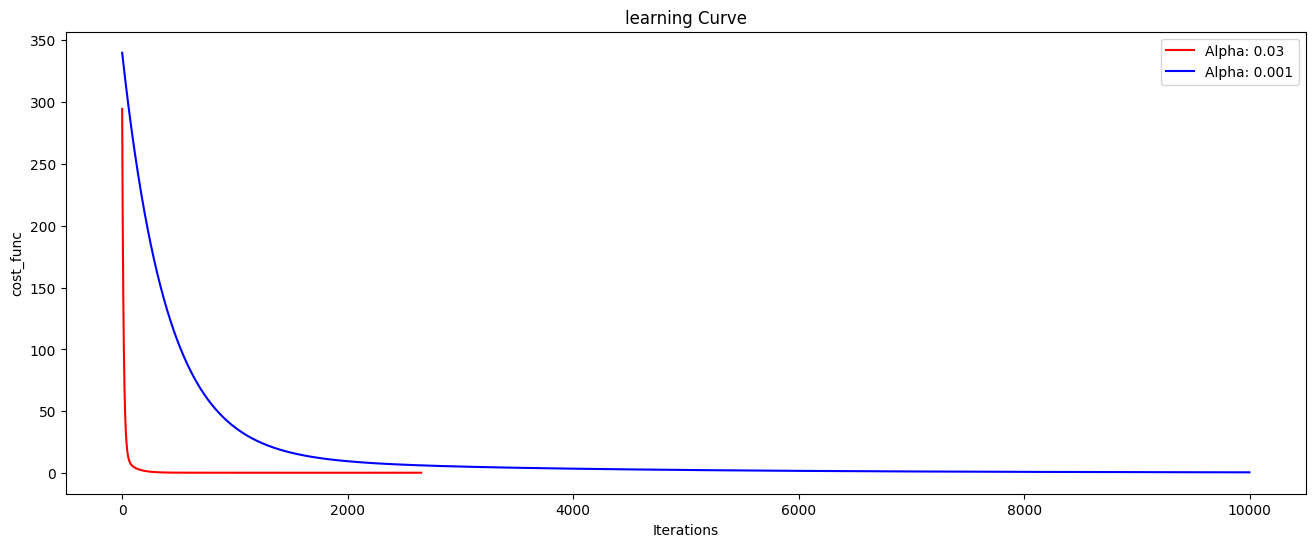

In [10]:
fig = plt.figure(figsize=(16, 6))
sns.lineplot(
    data=newdata,
    x=newdata.index.set_names("Iterations"),
    y=newdata["cost_func"],
    color="red",
    label="Alpha: 0.03",
)
sns.lineplot(
    data=newdata2,
    x=newdata2.index.set_names("Iterations"),
    y=newdata2["cost_func"],
    color="blue",
    label="Alpha: 0.001",
)
plt.title("learning Curve")
plt.savefig("../assets/2_linearregression1.png")

Will be taking the model with alpha=0.03 for further comparisons


In [11]:
wv = newdata.iloc[-1]["wv"]
b = newdata.iloc[-1]["b"]

### Comparison with Sklearn


In [12]:
lr = LinearRegression()
y_train = data["Performance Index"]
x_train = data.drop(columns=["Performance Index"])
lr.fit(x_train, y_train)
print("Sklearn Weights(wv):", lr.coef_)
print("Self Made Model Weights(wv):", np.array(wv))

print("Sklearn Intercept (b):", lr.intercept_)
print("Self Made Intercept (b):", b)

Sklearn Weights(wv): [ 7.38336987 17.6557312   0.63130645  0.80414252  0.54880281]
Self Made Model Weights(wv): [ 7.38336986 17.65573118  0.6313116   0.80414257  0.54880276]
Sklearn Intercept (b): 54.89793158735115
Self Made Intercept (b): 54.89792845113778


R^2


In [13]:
y_test = test_data["Performance Index"]
x_test = test_data.drop(columns=["Performance Index"])
y_pred_test_SELF = x_test.dot(wv) + b
rss_SELF = np.sum((y_test - y_pred_test_SELF) ** 2)
tss_SELF = np.sum((y_test - y_test.mean()) ** 2)

y_pred_test_SKL = x_test.dot(lr.coef_) + lr.intercept_
rss_SKL = np.sum((y_test - y_pred_test_SKL) ** 2)
tss_SKL = np.sum((y_test - y_test.mean()) ** 2)
r2_SELF = 1 - (rss_SELF / tss_SELF)
r2_SKL = 1 - (rss_SKL / tss_SKL)

print("R^2(Self):", r2_SELF)
print("R^2(SKlearn)", r2_SKL)

R^2(Self): 0.9883699129291678
R^2(SKlearn) 0.9883699138186105


### Actual vs Predicted Values Graph

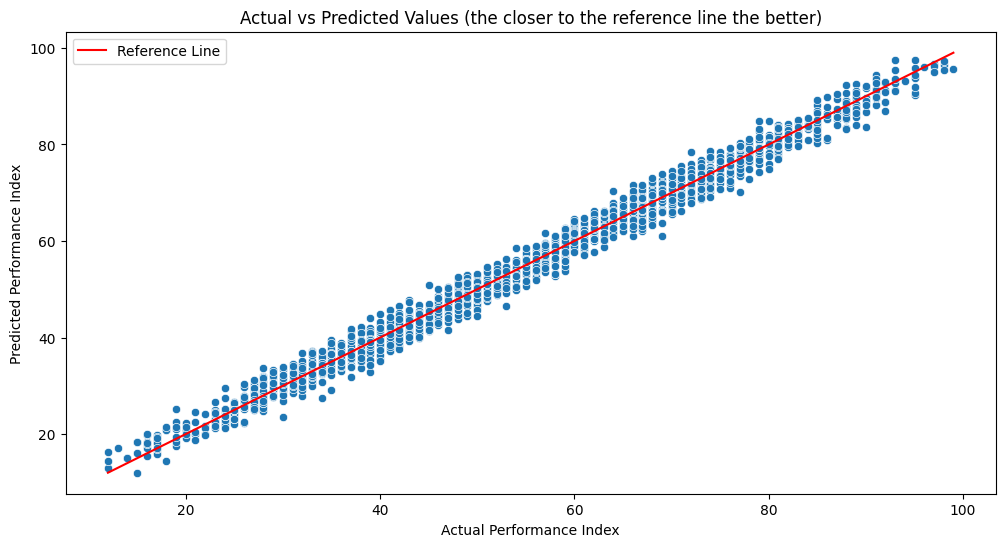

In [14]:
fig = plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_test_SELF)
sns.lineplot(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    color="red",
    label="Reference Line",
)
plt.title("Actual vs Predicted Values (the closer to the reference line the better)")
plt.xlabel("Actual Performance Index")
plt.ylabel("Predicted Performance Index")
plt.savefig("../assets/2_linearregression2.png")